<h1 style="font-size:3em; text-align: center">Modeling Uncertainty Using Dropout</h1>

Dropout is the random negation of all the weights tied to some fraction of neurons in a network. This means that if the dropout rate is set to 0.2, 1/5 of all neurons are "dropped" and the weights of the other neurons are increased by some ammount to make up for this drop. The neural network trains and adjusts the weights of the non-dropped weights. This process of dropping some fraction of neurons is repeated with each batch.

Normally, dropout is added to a neural network in order to avoid over-fitting, since the neurons don't get a chance to build up overwhelming ties. In this case, however, this dropout serves a second bonus: uncertainty. When running the prediction process, we will initiate the dropout process, which will vary the prediction each iteration.

Using all of these predictions, we calculate the average and the standard deviation. With this, we illustrate the uncertainty of the LSTM and its forecast.

In [57]:
# imports
import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
import math
import keras
from scipy.stats  import norm
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras        import backend as K
from datetime     import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics       import mean_squared_error
from matplotlib.pylab      import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 15, 6

# number of inputs to be fed
look_back = 288
# number of outputs to be generated
look_forward = 24

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1, look_forward=2):
    dataX, dataY = [], []
    np.array(dataY)
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        if len(dataset[i + look_back:i+look_back+look_forward, 0]) == look_forward:
            dataX.append(a)
            dataY.append(dataset[i + look_back:i+look_back+look_forward, 0])
    return np.array(dataX), np.array(dataY)

# predict_with_uncertainty

This function would activate dropout in the given model and runs the predictions **n_iter** times. It then returns 

* (1) a matrix of all of the prediction, 
* (2) a vector of size **look_back** containing the average predictions, and 
* (3) the standard deviation.

In [58]:
def predict_with_uncertainty(model, dataset, n_iter=100):
    # This function activates drop-out when doing predictions
    f = K.function([model.layers[0].input, K.learning_phase()],
                      [model.layers[-1].output])
    all_pred = np.zeros((n_iter,) + (1,look_forward,))
    for iter in range(n_iter):
        all_pred[iter] = f([dataset, 1])
    avg_pred = all_pred.mean(axis=0)
    std = np.std(all_pred, axis=0)
    return all_pred, avg_pred, std

In [59]:
# given a model and data from the original dataset, it uses predict_with_uncertainty to 
def run_predictions (model, dataset):
    # normalizes the dataset and prepares it to be fed to the model
    dataset = np.array(dataset).transpose().reshape(-1, 1)
    dataset = scaler.fit_transform(dataset).transpose()
    data = (dataset.T)
    data = data.reshape(1, 1, data.shape[0])
    # feeds the model and data into a function that will activate the dro-out
    all_pred, avg_pred, std = predict_with_uncertainty(model, data)
    
    # All the predictions
    all_pred = scaler.inverse_transform(all_pred.reshape(all_pred.shape[0], all_pred.shape[-1]))
    # The Average Prediction
    avg_pred = scaler.inverse_transform(avg_pred)
    # The Standard Deviation At Each T Of Prediction
    std = scaler.inverse_transform(std)
    
    return all_pred, avg_pred, std

In [60]:
def predict (model=model, day=11, total_days=1, delta=1, show_gradual_error=True):
    # creates matrices to hold the 
    avg_preds = np.zeros((288*total_days/delta, look_forward))
    true_vals = np.zeros((288*total_days/delta, look_forward))
    
    percent_over = np.zeros(288*total_days/delta)
    # Runs all the predictions
    for i in range (288*total_days/delta):
        # the point where the model will predict
        point = 288*day + i * delta
        
        # Gets predictions
        all_pred, avg_pred, std = run_predictions (model, dataset_orig[point-look_back:point].reshape(look_back))
        
        # Reshapes all of the things
        true_val = dataset_orig[point:point+look_forward].reshape(look_forward)
        avg_pred = avg_pred.reshape(look_forward)
        std = std.reshape(look_forward)
        
        percent_over[i] = 100.0 * (np.ones((len(all_pred),1) )*true_val - all_pred < 0).sum() / all_pred.size
        # plots the uncertainty to the degree of half a standard deviation
        plt.fill_between(range(point, point+look_forward), 
                         avg_pred + std/2.0, 
                         avg_pred - std/2.0, 
                         facecolor='red', alpha=0.25)
        
        # plots the uncertainty to the degree of a full standard deviation
        plt.fill_between(range(point, point+look_forward), 
                         avg_pred + std, 
                         avg_pred - std, 
                         facecolor='red', alpha=0.25)
        
        # plots the predictions
        plt.plot(range(point, point+look_forward), avg_pred, color='red', alpha=1)
        
        avg_preds[i], true_vals[i] = avg_pred, true_val
        
    # Reshapes the predictions and true vals to calculate the error
    plt.plot( np.arange(288*total_days+look_forward) + 288 * day, dataset_orig[288*day:288*day+288*total_days + look_forward,0])
    plt.axhline(0)
    plt.show()
    if show_gradual_error:
        indiv_err = true_vals - avg_preds
        for i in range(look_forward):
            plt.scatter(np.ones(len(indiv_err[:,i]))*i,indiv_err[:,i], color='black',alpha=0.1)
        plt.axhline(0)
        plt.show()
        print "Percent Overestimating: {}".format(np.mean(percent_over))

In [61]:
def over_penalty(y_true, y_pred):
    true_error = y_true - y_pred
    # doubles the error if the prediction is negative
    return  K.square(true_error) * K.square(K.sign(true_error) - 0.6)

In [62]:
# The interval between each dataset (original data in 5 minute intervals)
time_grouping = '5min'

# load the dataset
dataframe = pd.read_csv('ignored_assets/paxout_table.csv', engine='python', nrows=288*21)
dataframe['time_bucket'] = pd.to_datetime(dataframe['time_bucket'])
dataframe = dataframe.set_index('time_bucket')
dataframe['total'] = dataframe.sum(axis=1)
dataframe['day_hour'] = dataframe.index.round(time_grouping)

# The data set with the sum of all the cars out at the 
dataframe = dataframe[['total','day_hour']].groupby('day_hour').sum()

dataset_orig = dataframe.values
dataset_orig = dataset_orig.astype('float32')

# scale the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset_orig)

# split into train and test sets
train_size = 288*14
test_size = len(dataset) - train_size
test, train = dataset[0:test_size,:], dataset[test_size:len(dataset)-look_forward,:]

# reshape into X=[t, t-1, t-2,..., t-look_back] and Y=[t+1, t+2,... t+look_forward]
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Epoch 1/5
15s - loss: 0.0089
Epoch 2/5
15s - loss: 0.0060
Epoch 3/5
15s - loss: 0.0053
Epoch 4/5
15s - loss: 0.0049
Epoch 5/5
15s - loss: 0.0045
Epoch 1/1
15s - loss: 0.0044
Epoch 1/1
15s - loss: 0.0043
Epoch 1/1
15s - loss: 0.0040
Epoch 1/1
15s - loss: 0.0042
Epoch 1/1
15s - loss: 0.0039
Epoch 1/1
15s - loss: 0.0041
Epoch 1/1
15s - loss: 0.0040
Epoch 1/1
15s - loss: 0.0041
Epoch 1/1
15s - loss: 0.0042
Epoch 1/1
15s - loss: 0.0045
Epoch 1/1
15s - loss: 0.0042
Epoch 1/1
15s - loss: 0.0043
Epoch 1/1
15s - loss: 0.0043
Epoch 1/1
15s - loss: 0.0045
Epoch 1/1
15s - loss: 0.0041
Epoch 1/1
15s - loss: 0.0042
Epoch 1/1
15s - loss: 0.0043
Epoch 1/1
15s - loss: 0.0042
Epoch 1/1
15s - loss: 0.0043
Epoch 1/1
15s - loss: 0.0042


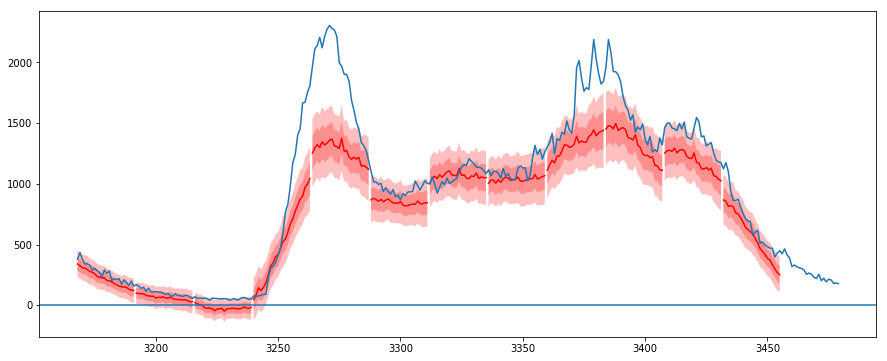

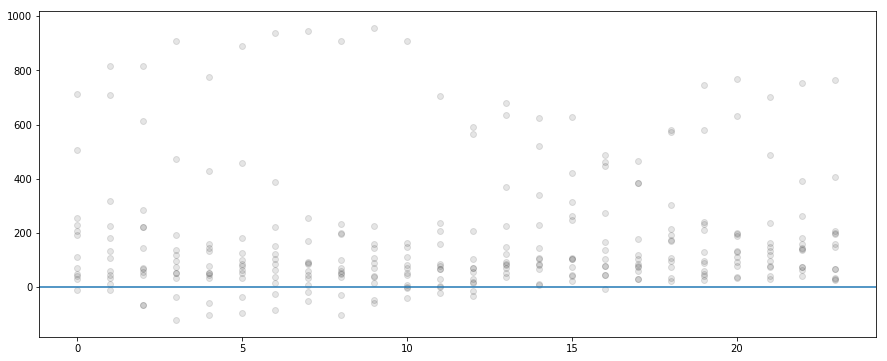

Percent Overestimating: 21.7777777778


In [56]:
# creates a model but does not compile the model
def create_model(rate = 0.2):
    model = Sequential()
    model.add(Dropout(rate, input_shape=(1, look_back)))
    lstm = LSTM(256, recurrent_dropout=0.3)
    model.add(lstm)
    model.add(Dropout(rate))
    model.add(Dense(128))
    model.add(Dropout(rate))
    model.add(Dense(128))
    model.add(Dropout(rate))
    model.add(Dense(128))
    model.add(Dense(look_forward))
    return model

batch = 1
seed = 11
np.random.seed(seed)
# create and fit the LSTM network
model = create_model(rate=0.2)
model.compile(loss=over_penalty, optimizer=keras.optimizers.RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0002))
model.fit(trainX, trainY, epochs=5, batch_size=batch, verbose=2)
for i in range (20):
    model.fit(trainX, trainY, epochs=1, batch_size=batch, verbose=2)

predict(model, total_days=1,day=11,delta=24)

## Replacing the Custom Loss Function with the MSE Loss Function

Epoch 1/5
15s - loss: 0.0149
Epoch 2/5
15s - loss: 0.0084
Epoch 3/5
15s - loss: 0.0075
Epoch 4/5
15s - loss: 0.0067
Epoch 5/5
15s - loss: 0.0064
Epoch 1/1
15s - loss: 0.0060
Epoch 1/1
15s - loss: 0.0058
Epoch 1/1
15s - loss: 0.0056
Epoch 1/1
15s - loss: 0.0056
Epoch 1/1
15s - loss: 0.0055
Epoch 1/1
15s - loss: 0.0054
Epoch 1/1
15s - loss: 0.0054
Epoch 1/1
15s - loss: 0.0054
Epoch 1/1
15s - loss: 0.0052
Epoch 1/1
15s - loss: 0.0051
Epoch 1/1
15s - loss: 0.0051
Epoch 1/1
15s - loss: 0.0051
Epoch 1/1
15s - loss: 0.0051
Epoch 1/1
15s - loss: 0.0051
Epoch 1/1
15s - loss: 0.0050
Epoch 1/1
15s - loss: 0.0048
Epoch 1/1
15s - loss: 0.0049
Epoch 1/1
16s - loss: 0.0051
Epoch 1/1
15s - loss: 0.0049
Epoch 1/1
15s - loss: 0.0050


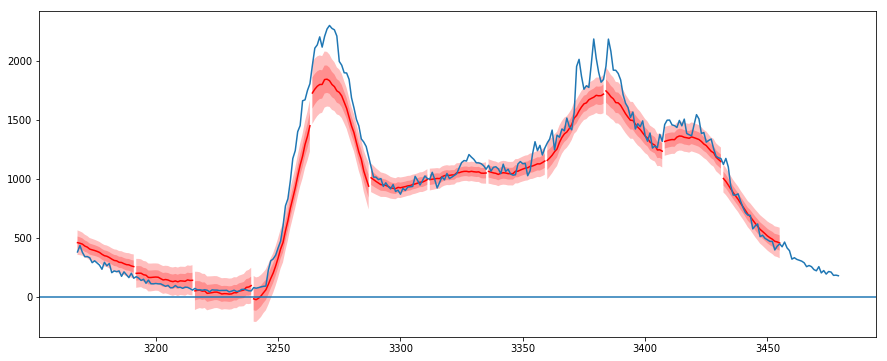

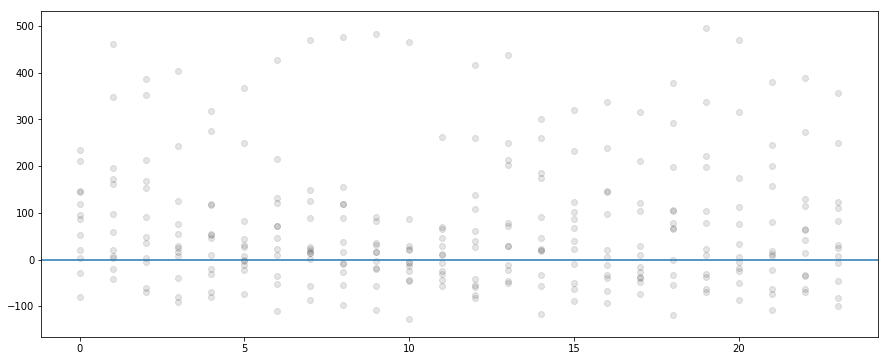

Percent Overestimating: 37.3229166667


In [63]:

batch = 1
seed = 11
np.random.seed(seed)
# create and fit the LSTM network
model = create_model(rate=0.2)
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0002))
model.fit(trainX, trainY, epochs=5, batch_size=batch, verbose=2)
for i in range (20):
    model.fit(trainX, trainY, epochs=1, batch_size=batch, verbose=2)

predict(model, total_days=1,day=11,delta=24)